#### Библиотеки 

In [1]:
import os 
from sklearn.metrics import accuracy_score
import torch
import torchvision
from torchvision import datasets
from torchvision import transforms as T 
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split
from torchvision import models
from torchvision.models.vision_transformer import vit_b_16
from torchvision.models import ViT_B_16_Weights
from torchvision.models.feature_extraction import get_graph_node_names, create_feature_extractor
import torchvision.transforms as transforms
from tqdm import tqdm
import matplotlib.pyplot as plt 

### 1.	Выбор начальных условий
#### a. Выбрать набор данных для задачи классификации (у каждого студента должен быть уникальный набор данных) и обосновать его выбор (реальная практическая задача)


##### Датасет 
- Датасет состоит из фотографий фруктов 
- Датасет содержит 10 классов
- Датасет содержит 3326 фото
- 1025 фото выделено на тестовую выборку, 2301 на обучающую
- Классификатор фруктов может быть использован в различных системах искусственного интеллекта. К примеру в магазинах, где ИИ будет пробивать товары для покупателя.


#### b.	Выбрать метрики качества и обосновать их выбор
Основная метрика для задачи классификации - это метрика точности(accuracy). Будем использовать ее 

In [5]:
# Получить классы 
def get_classes(data_dir):
    all_data = datasets.ImageFolder(data_dir)
    return all_data.classes

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))  # Normalize to [-1, 1]
])

In [6]:
train_data = datasets.ImageFolder('MY_data/train/', transform = transform)
train_loader = DataLoader(train_data, batch_size=128, shuffle=True, num_workers=4, )
test_data = datasets.ImageFolder('MY_data/test/', transform = transform)
test_loader = DataLoader(test_data, batch_size=128, shuffle=True, num_workers=4)

In [7]:
classes = get_classes('MY_data/train/')
print(classes, len(classes))


['Apple', 'Banana', 'avocado', 'cherry', 'kiwi', 'mango', 'orange', 'pinenapple', 'strawberries', 'watermelon'] 10


### 2.	Создание бейзлайна и оценка качества
#### a.	Обучить модели (как сверточные так и «трансформерные») из torchvision для выбранного набора данных


In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

##### Функция для обучения

In [11]:
def train(model, train_dataloader,test_dataloader, loss_fn, optimizer, device): 
    model.train()  
    total_loss_train = 0 
    total_correct_train = 0 
    total_loss_test = 0 
    total_correct_test = 0
    total_count = 0
    for batch in train_dataloader:
        inputs, labels = batch[0].to(device), batch[1].to(device)
        optimizer.zero_grad() #
        outputs = model(inputs)

        loss = loss_fn(outputs, labels)

        loss.backward()     
        optimizer.step()    
        total_loss_train += loss.item()

        predictions = outputs.argmax(dim=1)

        correct = (predictions == labels).sum().item()
        total_correct_train += correct
        total_count += len(labels)

    total_correct_train = total_correct_train / total_count
    total_loss_train = total_loss_train / total_count

    total_count = 0
    for batch in test_dataloader:
        inputs, labels = batch[0].to(device), batch[1].to(device)
        
        outputs = model(inputs)

        loss = loss_fn(outputs, labels)

          
        total_loss_test += loss.item()

        predictions = outputs.argmax(dim=1)

        correct = (predictions == labels).sum().item()
        total_correct_test += correct
        total_count += len(labels)

    total_correct_test = total_correct_test / total_count
    total_loss_test = total_loss_test / total_count

    return total_loss_train, total_correct_train, total_loss_test, total_correct_test

In [12]:
def plot_metrics(all_total_loss_train, all_total_correct_train, all_total_loss_test, all_total_correct_test):

    f, axarr = plt.subplots(1,2)
    axarr[0].plot([i for i in range(len(all_total_correct_train))],
                    all_total_correct_train, label='Train accuracy',c='b')
    axarr[0].plot([i for i in range(len(all_total_correct_test))],
                    all_total_correct_test, label='test accuracy', c='r')
    axarr[1].plot([i for i in range(len(all_total_loss_train))],
                    all_total_loss_train, label='Train loss')
    axarr[1].plot([i for i in range(len(all_total_loss_test))],
                    all_total_loss_test, label='test loss')
    axarr[0].legend()
    axarr[1].legend()

In [13]:
def best_acc(all_total_correct_test):
    for i in range(len(all_total_correct_test)):
    
        if all_total_correct_test[i] == max(all_total_correct_test):
    
            print(f'Лучшее качество на тесте на эпохе {i + 1} = {max(all_total_correct_test)}')
            break

##### Модель трансформер

In [15]:
class ModifiedViT(nn.Module):
    def __init__(self, pretrained_model):
        super(ModifiedViT, self).__init__()
        self.pretrained = pretrained_model
        self.pretrained.head = torch.nn.Identity()  # remove the existing linear layer
        self.new_head = torch.nn.Sequential(
            torch.nn.Linear(1000, 10),  # Adjust the input size to match the output size of the ViT model
        )
        

    def forward(self, x):
        x = self.pretrained(x)
        x = self.new_head(x)
        return x



In [16]:
vit_b_16 = models.vit_b_16(pretrained=True)
modified_vit_b_16 = ModifiedViT(vit_b_16)
num_epochs = 30 
loss_fn = torch.nn.CrossEntropyLoss()
model = modified_vit_b_16
# Disable gradients for everything
model.requires_grad_(False)
model.new_head.requires_grad_(True)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
model.to(device)


C:\Users\isazo\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\isazo\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ModifiedViT(
  (pretrained): VisionTransformer(
    (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (encoder): Encoder(
      (dropout): Dropout(p=0.0, inplace=False)
      (layers): Sequential(
        (encoder_layer_0): EncoderBlock(
          (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (self_attention): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (dropout): Dropout(p=0.0, inplace=False)
          (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): MLPBlock(
            (0): Linear(in_features=768, out_features=3072, bias=True)
            (1): GELU(approximate='none')
            (2): Dropout(p=0.0, inplace=False)
            (3): Linear(in_features=3072, out_features=768, bias=True)
            (4): Dropout(p=0.0, inplace=False)
          )
        )
        (encoder_layer_1): EncoderBlock(
          (ln_1)

In [17]:
all_total_loss_train, all_total_correct_train, all_total_loss_test, all_total_correct_test = [], [], [], []
for epoch in range(num_epochs):
    total_loss_train, total_correct_train, total_loss_test, total_correct_test = train(model, train_loader, test_loader, loss_fn, optimizer, device, )
    all_total_loss_train.append(total_loss_train)
    all_total_correct_train.append(total_correct_train)
    all_total_loss_test.append(total_loss_test)
    all_total_correct_test.append(total_correct_test)
    
    print(f'на эпохе {epoch+1} train_loss = {total_loss_train}, train_accuracy = {total_correct_train}, train_loss = {total_loss_test}, test_accuracy = {total_correct_test}')


на эпохе 1 train_loss = 0.015755930241166588, train_accuracy = 0.37809647979139505, train_loss = 0.014992902220749274, test_accuracy = 0.5736585365853658
на эпохе 2 train_loss = 0.009332967680052848, train_accuracy = 0.8100825727944372, train_loss = 0.011307977234444967, test_accuracy = 0.655609756097561
на эпохе 3 train_loss = 0.005864287344904787, train_accuracy = 0.8826597131681877, train_loss = 0.01030652246824125, test_accuracy = 0.6760975609756098
на эпохе 4 train_loss = 0.0044448429452290175, train_accuracy = 0.8996088657105606, train_loss = 0.010209714486831572, test_accuracy = 0.6839024390243903
на эпохе 5 train_loss = 0.003738973968083938, train_accuracy = 0.9096045197740112, train_loss = 0.012764154294642007, test_accuracy = 0.6878048780487804
на эпохе 6 train_loss = 0.003302756844267333, train_accuracy = 0.9152542372881356, train_loss = 0.01076492190361023, test_accuracy = 0.686829268292683
на эпохе 7 train_loss = 0.003003234256614244, train_accuracy = 0.9269882659713168, t

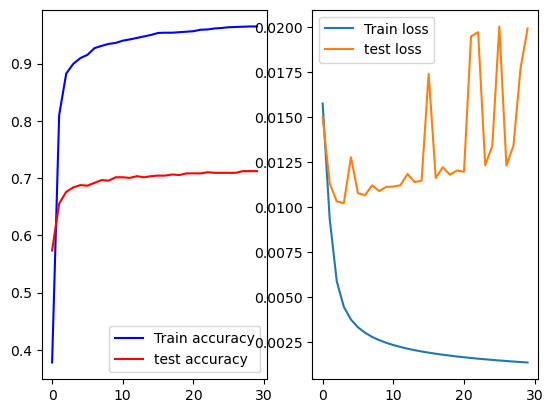

In [18]:
plot_metrics(all_total_loss_train, all_total_correct_train, all_total_loss_test, all_total_correct_test)

In [19]:
best_acc(all_total_correct_test)

Лучшее качество на тесте на эпохе 28 = 0.7121951219512195


#### Сверточная модель

In [21]:
model = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)

model.requires_grad_(False)
model.fc.requires_grad_(True)

model = model.to(device)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)



In [22]:
all_total_loss_train, all_total_correct_train, all_total_loss_test, all_total_correct_test = [], [], [], []
for epoch in range(num_epochs):
    total_loss_train, total_correct_train, total_loss_test, total_correct_test = train(model, train_loader, test_loader, loss_fn, optimizer, device, )
    all_total_loss_train.append(total_loss_train)
    all_total_correct_train.append(total_correct_train)
    all_total_loss_test.append(total_loss_test)
    all_total_correct_test.append(total_correct_test)
    
    print(f'на эпохе {epoch+1} train_loss = {total_loss_train}, train_accuracy = {total_correct_train}, train_loss = {total_loss_test}, test_accuracy = {total_correct_test}')


на эпохе 1 train_loss = 0.018785130298951045, train_accuracy = 0.12994350282485875, train_loss = 0.0187382953922923, test_accuracy = 0.27121951219512197
на эпохе 2 train_loss = 0.013915022214253744, train_accuracy = 0.5097783572359843, train_loss = 0.015300097581816883, test_accuracy = 0.5063414634146342
на эпохе 3 train_loss = 0.01023557065933075, train_accuracy = 0.7344632768361582, train_loss = 0.013610073996753227, test_accuracy = 0.56
на эпохе 4 train_loss = 0.008026141127727695, train_accuracy = 0.8166014776184267, train_loss = 0.012944792305550925, test_accuracy = 0.5960975609756097
на эпохе 5 train_loss = 0.006700703057451178, train_accuracy = 0.8457192524989136, train_loss = 0.012911656077315167, test_accuracy = 0.6107317073170732
на эпохе 6 train_loss = 0.005857003196225587, train_accuracy = 0.8674489352455454, train_loss = 0.012825619651050103, test_accuracy = 0.6273170731707317
на эпохе 7 train_loss = 0.00523878957125893, train_accuracy = 0.8717948717948718, train_loss = 0.

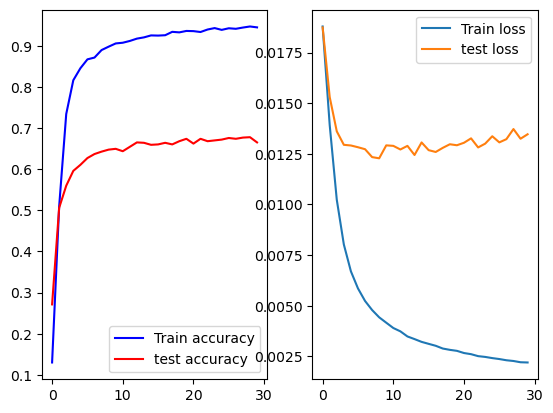

In [23]:
plot_metrics(all_total_loss_train, all_total_correct_train, all_total_loss_test, all_total_correct_test)

In [24]:
best_acc(all_total_correct_test)

Лучшее качество на тесте на эпохе 29 = 0.6780487804878049


##### Выводы 
- Трансформерная модель показала лучшее качество на тестовой выборке
- Разница точности для обоих моделей на обучающей и тестовой выборке состовляет примерно 0.25-0.28
- Лучшее качество для трансформерной модели на тесте на эпохе 28 = 0.7121951219512195
- Лучшее качество для сверточной модели на тесте на эпохе 26 = 0.6848780487804879

### 3.	Улучшение бейзлайна
- Сформулировать гипотезы (аугментации данных, подбор моделей, подбор гиперпараметров и т.д.)
- Проверить гипотезы
- Сформировать улучшенный бейзлайн по результатам проверки гипотез
- Обучить модели с улучшенным бейзлайном на выбранном наборе данных
- Оценить качество моделей с улучшенным бейзлайном по выбранным метрикам на выбранном наборе данных
- Сравнить результаты моделей с улучшенным бейзлайном в сравнении с результатами из пункта 2 
- Сделать выводы


### Формулировка гипотез 
##### Гипотеза 1 - Аугментация данных при помощи рандомного выреза и и рандомного поворота может улучшить качество моделей на тестовой выборке 
##### Гипотеза 2 - Изменение параметров lr, momentum,  для SGD может  улучшить качество моделей на тестовой выборке 
##### Гипотеза 3 - Увеличение количества эпох способно улучшить качество моделей на тестовой выборке 

In [28]:
def big_train(model = 'vit', lr=0.001, momentum=0.9, epochs = 30):
    if model == 'vit':

        vit_b_16 = models.vit_b_16(pretrained=True)
        modified_vit_b_16 = ModifiedViT(vit_b_16)
        num_epochs = epochs 
        loss_fn = torch.nn.CrossEntropyLoss()
        model = modified_vit_b_16
        # Disable gradients for everything
        model.requires_grad_(False)
        model.new_head.requires_grad_(True)
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
        model.to(device)
        

    else:

        model = models.resnet18(weights='IMAGENET1K_V1')
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, 10)
        
        model.requires_grad_(False)
        model.fc.requires_grad_(True)
        
        model = model.to(device)
        loss_fn = torch.nn.CrossEntropyLoss()
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)


    all_total_loss_train, all_total_correct_train, all_total_loss_test, all_total_correct_test = [], [], [], []
    for epoch in range(epochs):
        total_loss_train, total_correct_train, total_loss_test, total_correct_test = train(model, train_loader, test_loader, loss_fn, optimizer, device, )
        all_total_loss_train.append(total_loss_train)
        all_total_correct_train.append(total_correct_train)
        all_total_loss_test.append(total_loss_test)
        all_total_correct_test.append(total_correct_test)
            
        print(f'на эпохе {epoch+1} train_loss = {total_loss_train}, train_accuracy = {total_correct_train}, train_loss = {total_loss_test}, test_accuracy = {total_correct_test}')

    plot_metrics(all_total_loss_train, all_total_correct_train, all_total_loss_test, all_total_correct_test)
    best_acc(all_total_correct_test)

        
    return max(all_total_correct_test)
        

#### Гипотеза 1 - Аугментация данных при помощи рандомного выреза и и рандомного поворота может улучшить качество моделей на тестовой выборке 

In [30]:
# Добовляем аугментаци
transform = transforms.Compose([
    transforms.RandomResizedCrop(size=(224, 224), antialias=True),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))  # Normalize to [-1, 1]
])

train_data = datasets.ImageFolder('MY_data/train/', transform = transform)
train_loader = DataLoader(train_data, batch_size=128, shuffle=True, num_workers=4, )
test_data = datasets.ImageFolder('MY_data/test/', transform = transform)
test_loader = DataLoader(test_data, batch_size=128, shuffle=True, num_workers=4)

на эпохе 1 train_loss = 0.016677148494446913, train_accuracy = 0.28292046936114734, train_loss = 0.01558440964396407, test_accuracy = 0.5258536585365854
на эпохе 2 train_loss = 0.010432427678611786, train_accuracy = 0.7357670578009561, train_loss = 0.011794308569373154, test_accuracy = 0.6107317073170732
на эпохе 3 train_loss = 0.006848753897431932, train_accuracy = 0.848761408083442, train_loss = 0.011369794519936166, test_accuracy = 0.6634146341463415
на эпохе 4 train_loss = 0.005413535184209526, train_accuracy = 0.8518035636679705, train_loss = 0.01094504682029166, test_accuracy = 0.6478048780487805
на эпохе 5 train_loss = 0.004685162694906992, train_accuracy = 0.8735332464146024, train_loss = 0.010217295485298808, test_accuracy = 0.6780487804878049
на эпохе 6 train_loss = 0.004234835576720986, train_accuracy = 0.877444589308996, train_loss = 0.010551723183655158, test_accuracy = 0.6702439024390244
на эпохе 7 train_loss = 0.0038008550517924814, train_accuracy = 0.8878748370273793, t

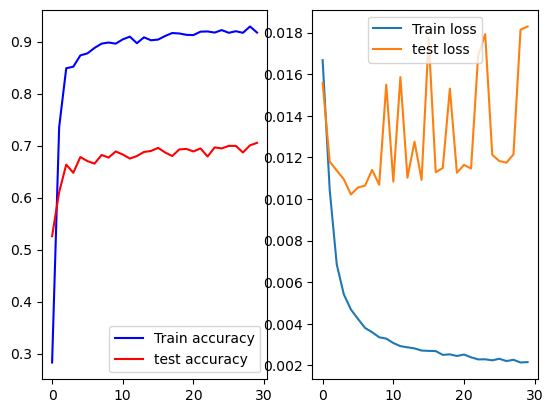

In [31]:
# Трансформерная модель 
_ = big_train()

на эпохе 1 train_loss = 0.0176121441502511, train_accuracy = 0.17687961755758366, train_loss = 0.01845963757212569, test_accuracy = 0.30048780487804877
на эпохе 2 train_loss = 0.014089353962184968, train_accuracy = 0.4867448935245545, train_loss = 0.015911905707382573, test_accuracy = 0.47609756097560973
на эпохе 3 train_loss = 0.01122846985733649, train_accuracy = 0.6718817905258583, train_loss = 0.014321719262658097, test_accuracy = 0.5482926829268293
на эпохе 4 train_loss = 0.009366087009988625, train_accuracy = 0.7401129943502824, train_loss = 0.013586889011103933, test_accuracy = 0.5570731707317074
на эпохе 5 train_loss = 0.008178856180108976, train_accuracy = 0.777922642329422, train_loss = 0.013450751886135195, test_accuracy = 0.5853658536585366
на эпохе 6 train_loss = 0.0073537594440034135, train_accuracy = 0.8053020425901782, train_loss = 0.01302769916813548, test_accuracy = 0.5863414634146341
на эпохе 7 train_loss = 0.006659262805128035, train_accuracy = 0.8222511951325511, t

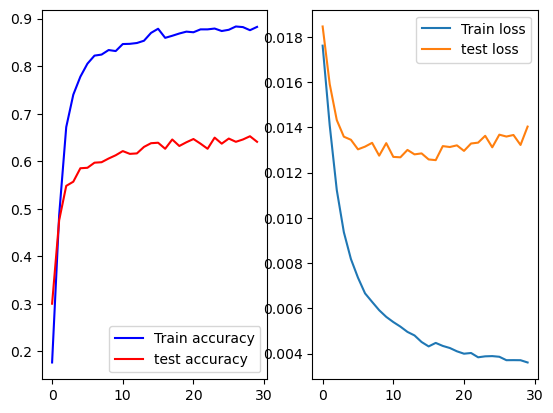

In [32]:
# Сверточная модель
_ = big_train(model = 'cnn')

#### Результаты проверки Гипотезы 
- Добавление аугментации не привело к значительному улучшению точности моделей на тествой выборке

#### Гипотеза 2 - Изменение параметров lr, momentum, для SGD может улучшить качество моделей на тестовой выборке

In [39]:
# Без аугментаци
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))  # Normalize to [-1, 1]
])
train_data = datasets.ImageFolder('MY_data/train/', transform = transform)
train_loader = DataLoader(train_data, batch_size=128, shuffle=True, num_workers=4, )
test_data = datasets.ImageFolder('MY_data/test/', transform = transform)
test_loader = DataLoader(test_data, batch_size=128, shuffle=True, num_workers=4)

In [41]:
lrs=[0.1, 0.01, 0.001, 0.0001 ]
momentums=[0.1, 0.3 , 0.5, 0.7, 0.9]

на эпохе 1 train_loss = 0.0058692114760387675, train_accuracy = 0.7696653628857019, train_loss = 0.011250575708179939, test_accuracy = 0.6985365853658536
на эпохе 2 train_loss = 0.002013770588995425, train_accuracy = 0.9356801390699696, train_loss = 0.012342018737662129, test_accuracy = 0.7092682926829268
на эпохе 3 train_loss = 0.001494930881435381, train_accuracy = 0.9539330725771403, train_loss = 0.013204435562578644, test_accuracy = 0.7014634146341463
на эпохе 4 train_loss = 0.001226815932965807, train_accuracy = 0.9643633202955237, train_loss = 0.013536716009058604, test_accuracy = 0.7082926829268292
на эпохе 5 train_loss = 0.0010650292725368252, train_accuracy = 0.9687092568448501, train_loss = 0.013712798400623042, test_accuracy = 0.713170731707317
на эпохе 6 train_loss = 0.0009389593776336498, train_accuracy = 0.974793568013907, train_loss = 0.019142409185083902, test_accuracy = 0.7170731707317073
на эпохе 7 train_loss = 0.0008252029319733757, train_accuracy = 0.979574098218166

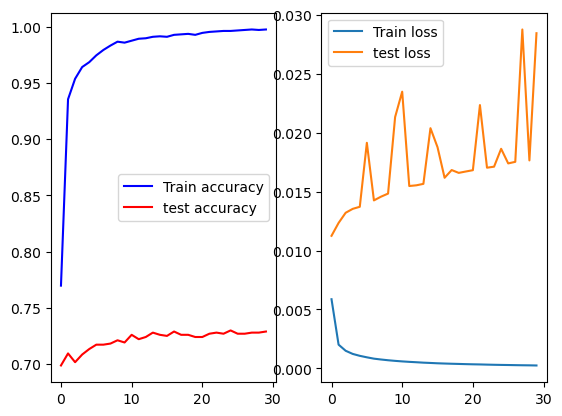

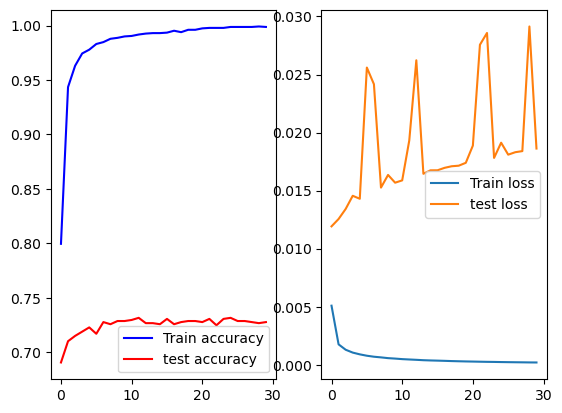

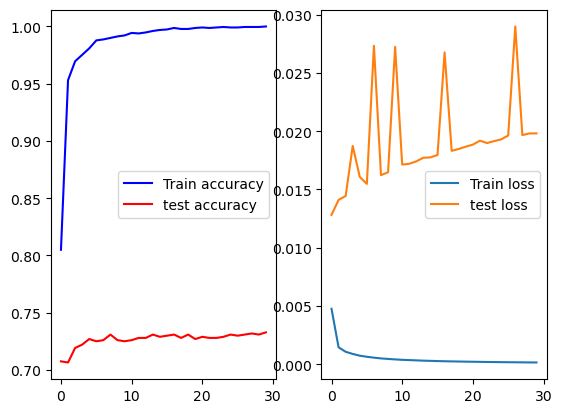

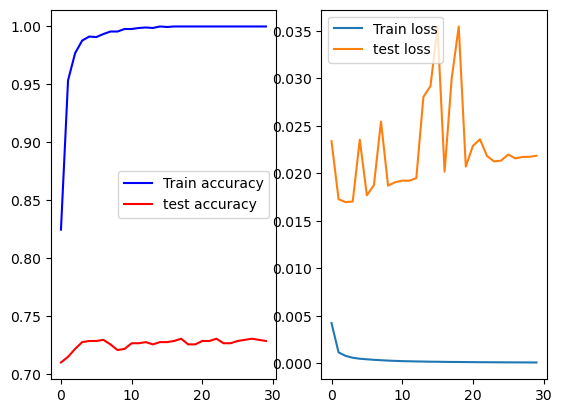

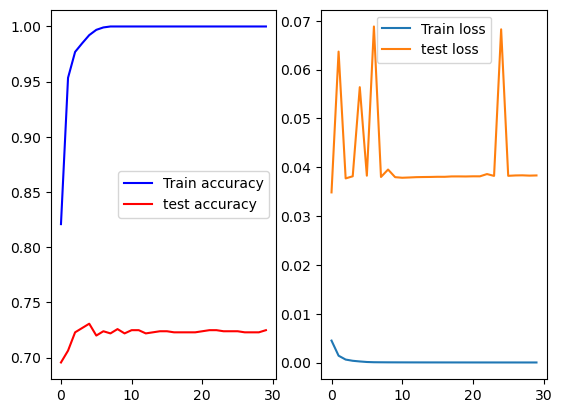

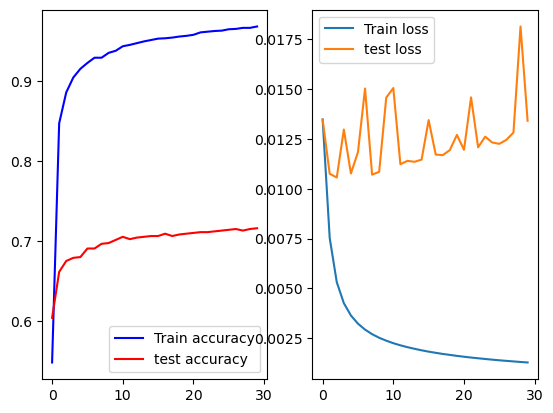

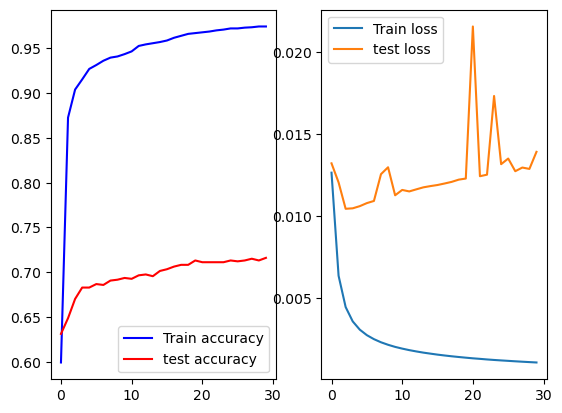

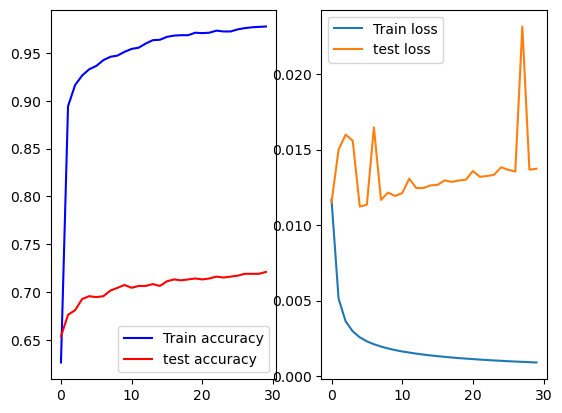

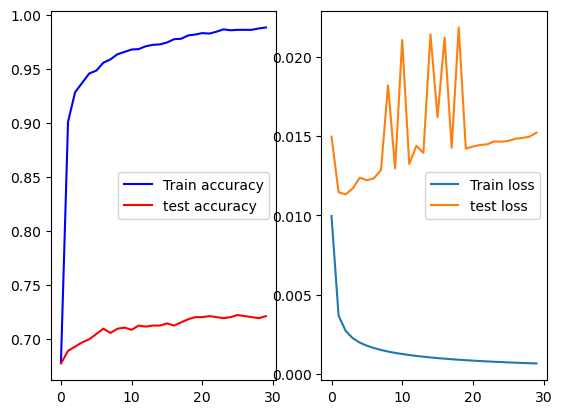

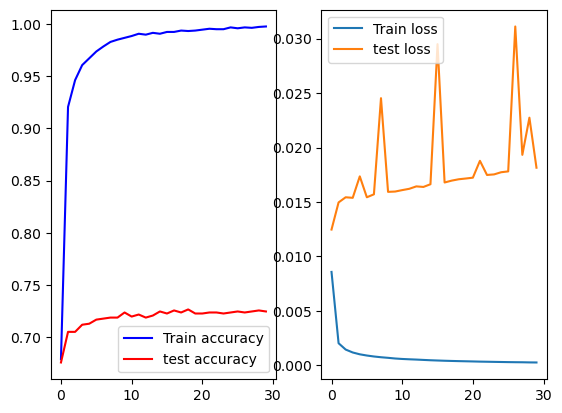

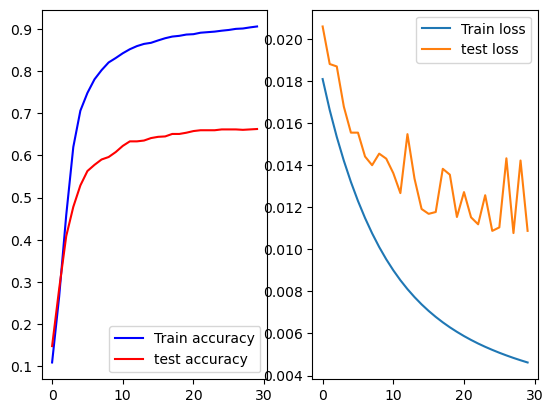

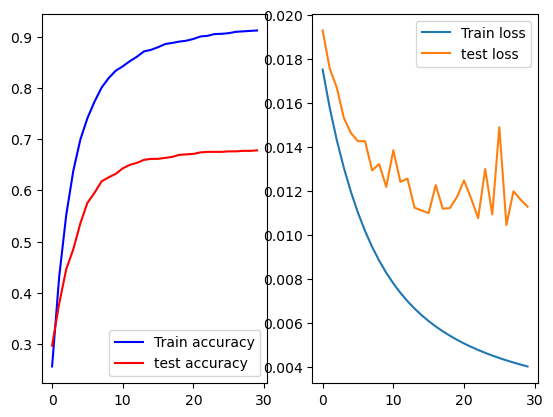

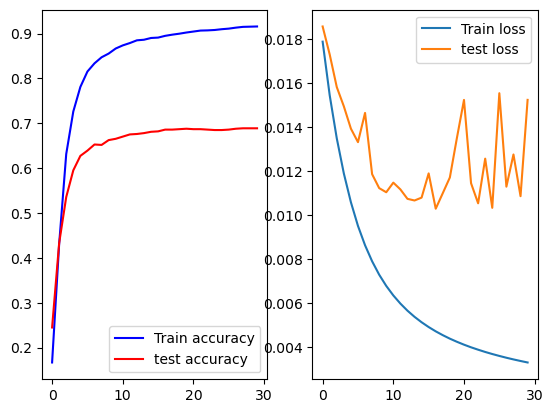

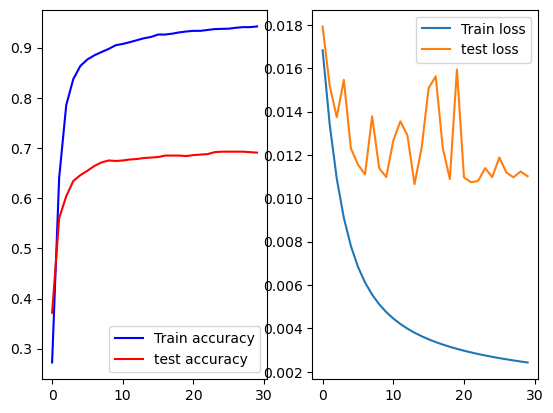

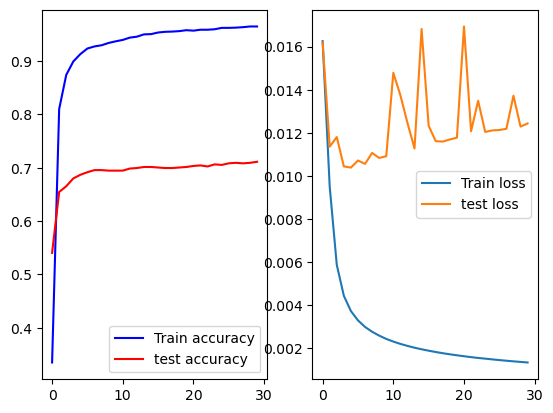

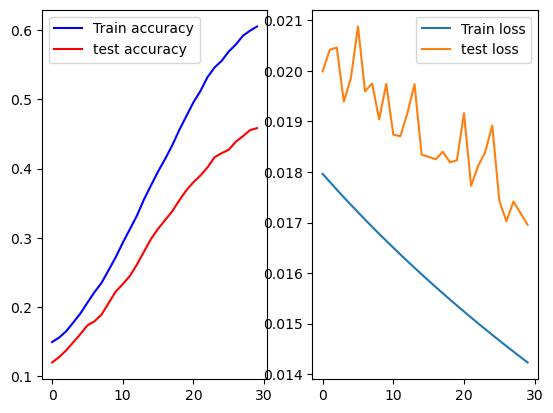

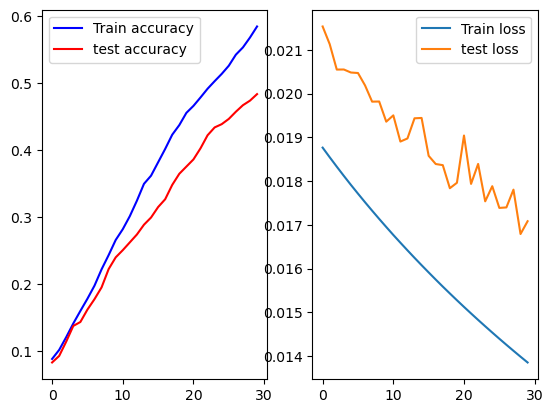

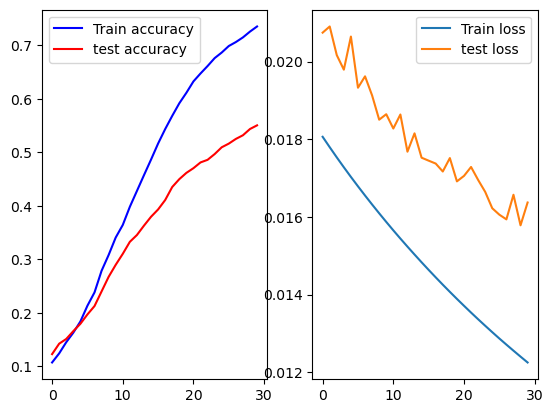

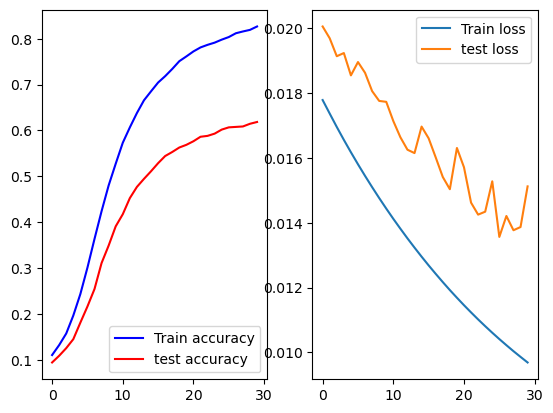

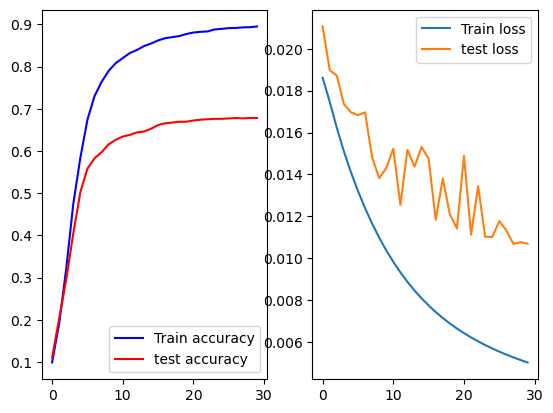

In [46]:
best_dict = {}
for i in lrs:

    for k in momentums:

        best_dict[(i,k)] = big_train(lr=i, momentum=k)

In [76]:
for i in best_dict.keys():
    if best_dict[i] == max(best_dict.values()):
        print(f'Лучшая точность на тесте = {max(best_dict.values())} при lr = {i[0]} и momentum = {i[1]}')

Лучшая точность на тесте = 0.7326829268292683 при lr = 0.1 и momentum = 0.5


на эпохе 1 train_loss = 0.026363880232280878, train_accuracy = 0.423728813559322, train_loss = 0.01958560966863865, test_accuracy = 0.5658536585365853
на эпохе 2 train_loss = 0.004243865356606953, train_accuracy = 0.8326814428509344, train_loss = 0.01603743099584812, test_accuracy = 0.6478048780487805
на эпохе 3 train_loss = 0.002280427315399886, train_accuracy = 0.9165580182529335, train_loss = 0.015751097144150152, test_accuracy = 0.6634146341463415
на эпохе 4 train_loss = 0.0018213028521291176, train_accuracy = 0.944806605823555, train_loss = 0.01675522408834318, test_accuracy = 0.6673170731707317
на эпохе 5 train_loss = 0.0017750370714883087, train_accuracy = 0.9391568883094307, train_loss = 0.016287229351881073, test_accuracy = 0.68
на эпохе 6 train_loss = 0.0015772777062714074, train_accuracy = 0.9521946979574099, train_loss = 0.017095055812742652, test_accuracy = 0.6858536585365854
на эпохе 7 train_loss = 0.0013956773551792125, train_accuracy = 0.9565406345067362, train_loss = 0

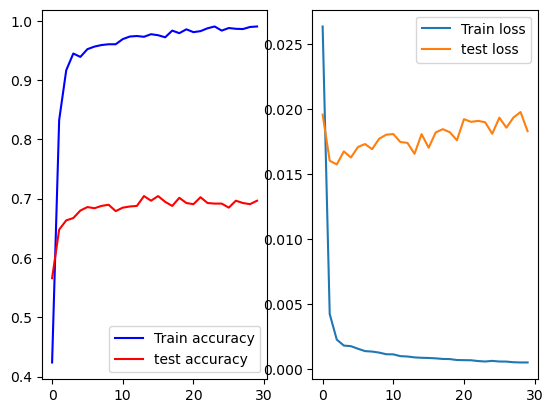

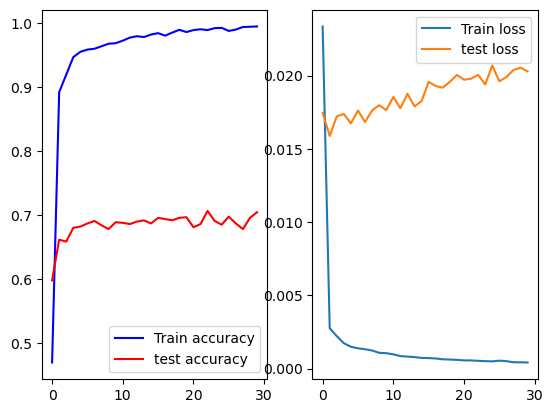

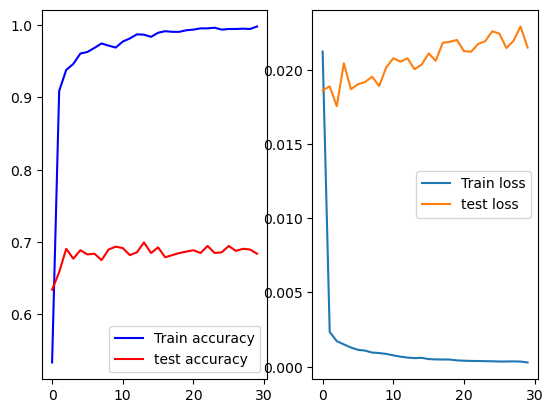

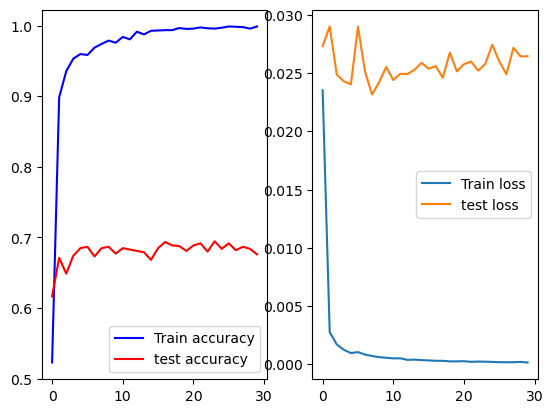

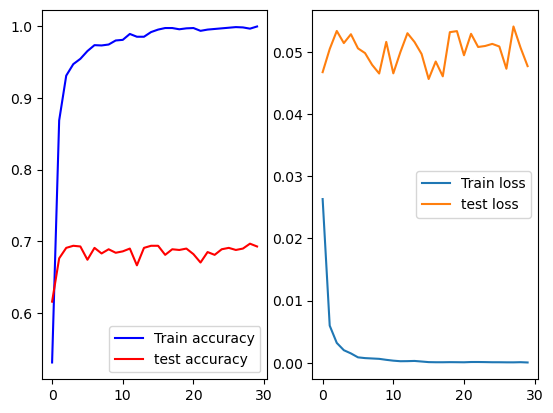

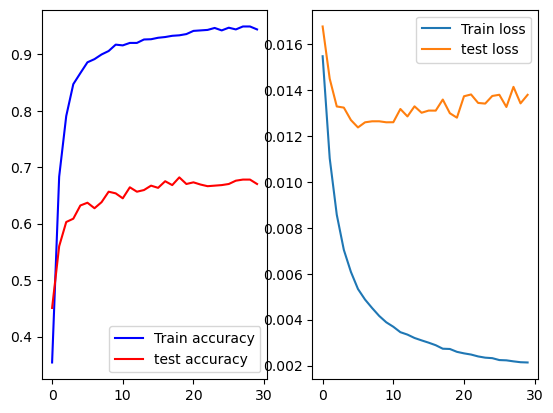

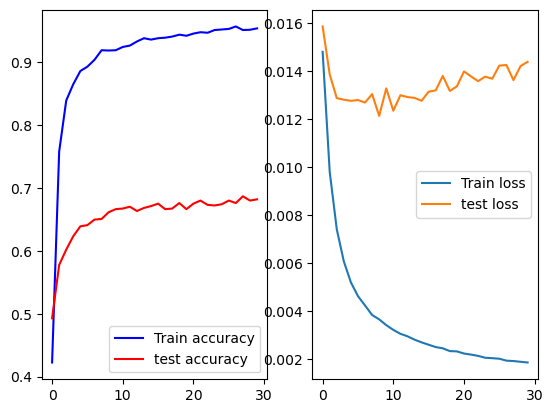

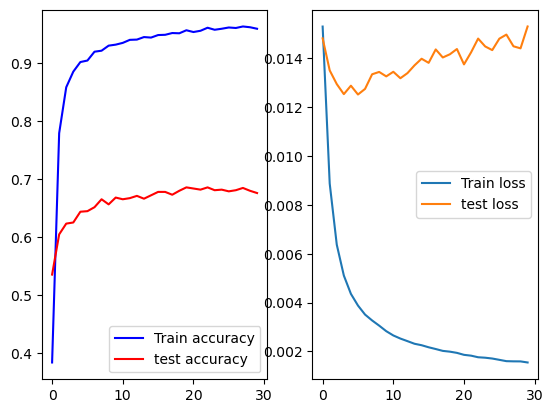

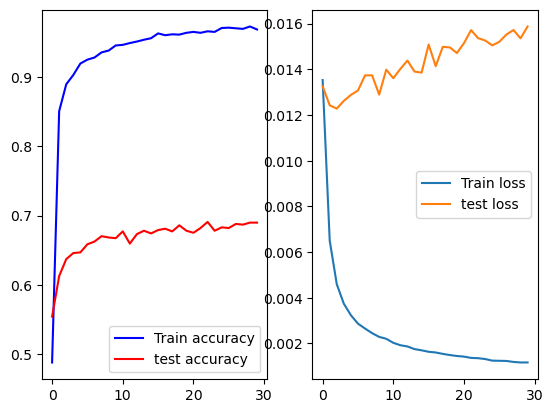

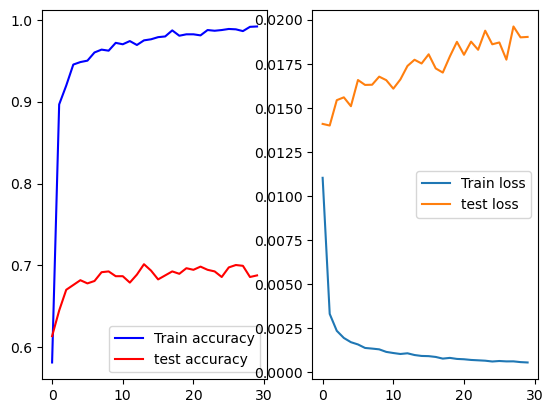

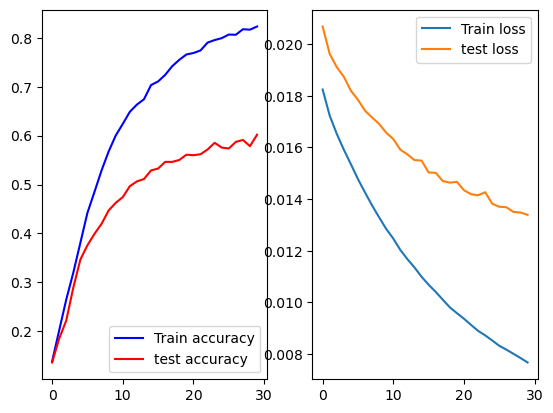

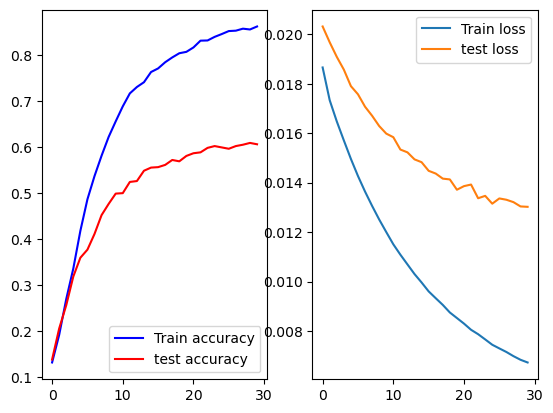

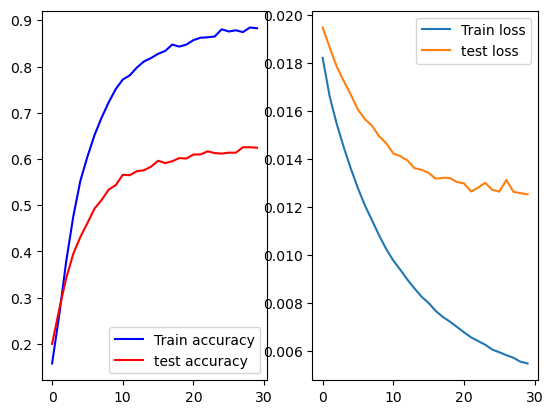

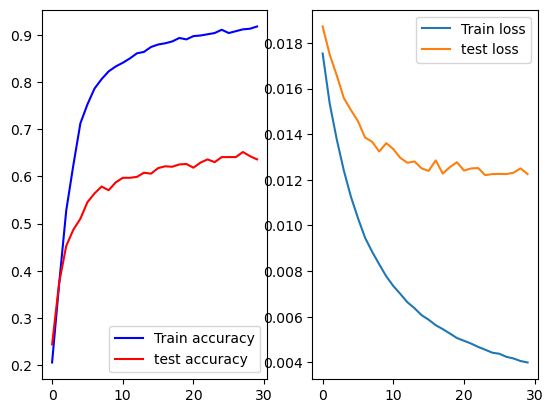

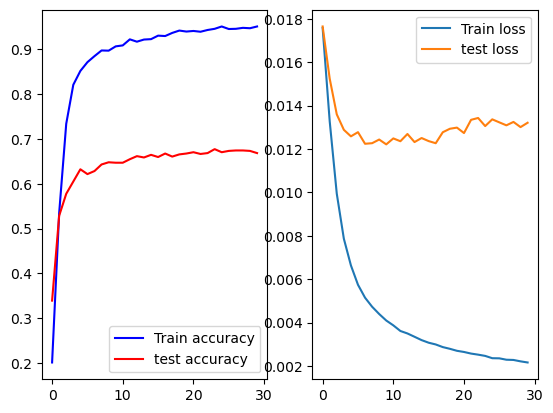

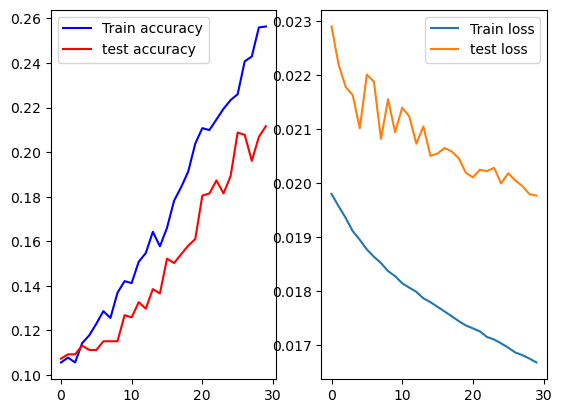

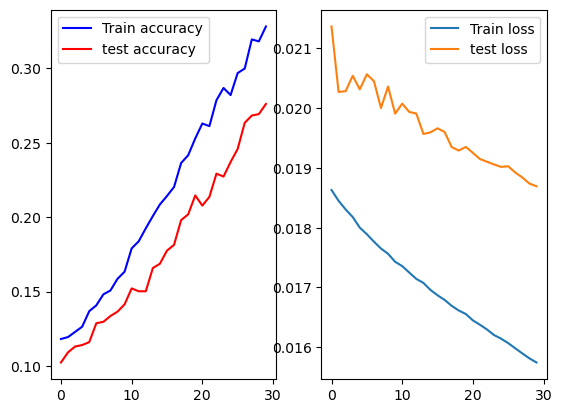

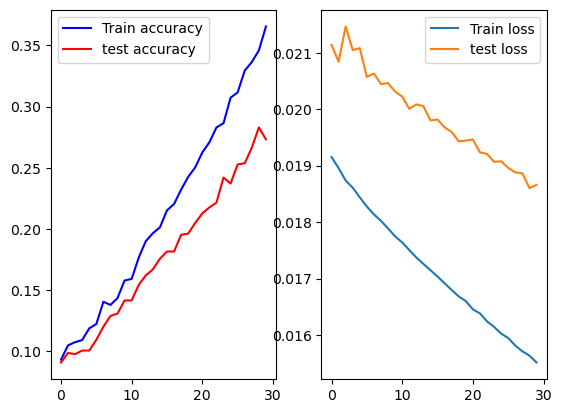

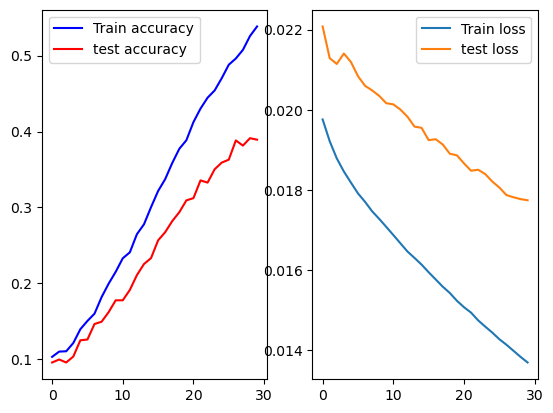

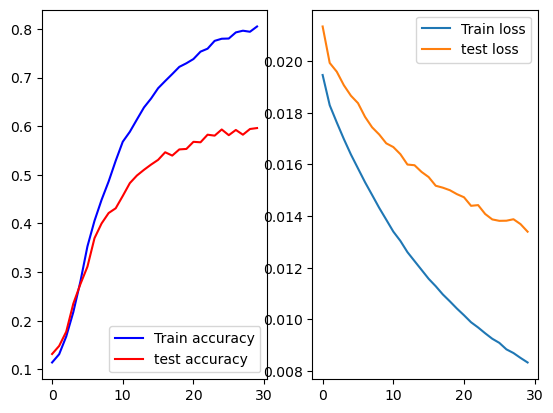

In [86]:
best_dict = {}
for i in lrs:

    for k in momentums:

        best_dict[(i,k)] = big_train(model = 'cnn', lr=i, momentum=k)

In [87]:
for i in best_dict.keys():
    if best_dict[i] == max(best_dict.values()):
        print(f'Лучшая точность на тесте = {max(best_dict.values())} при lr = {i[0]} и momentum = {i[1]}')

Лучшая точность на тесте = 0.7063414634146341 при lr = 0.1 и momentum = 0.3


#### Результаты проверки Гипотезы 
- Изменение параметров lr и momentum привело к росту качества.
- Для трансформерной модели лучшие параметры lr = 0.1 и momentum = 0.5
- Для сверточной модели лучшие параметры 0.1 и momentum = 0.3

#### Гипотеза 3 - Увеличение количества эпох способно улучшить качество моделей на тестовой выборке

In [90]:
epochs = [30,50,100]

C:\Users\isazo\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\isazo\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


на эпохе 1 train_loss = 0.01593478515530503, train_accuracy = 0.358974358974359, train_loss = 0.015595127547659526, test_accuracy = 0.5678048780487804
на эпохе 2 train_loss = 0.009470359650138978, train_accuracy = 0.7931334202520643, train_loss = 0.014761677835045792, test_accuracy = 0.6419512195121951
на эпохе 3 train_loss = 0.005960993795796924, train_accuracy = 0.864406779661017, train_loss = 0.010653261876687772, test_accuracy = 0.6653658536585366
на эпохе 4 train_loss = 0.004510768259778742, train_accuracy = 0.8926553672316384, train_loss = 0.010658438787227723, test_accuracy = 0.6751219512195122
на эпохе 5 train_loss = 0.003783555703803489, train_accuracy = 0.9074315514993481, train_loss = 0.01320083432081269, test_accuracy = 0.6848780487804879
на эпохе 6 train_loss = 0.003340397889797504, train_accuracy = 0.914819643633203, train_loss = 0.015447909657548114, test_accuracy = 0.688780487804878
на эпохе 7 train_loss = 0.003029329032806768, train_accuracy = 0.9217731421121251, train

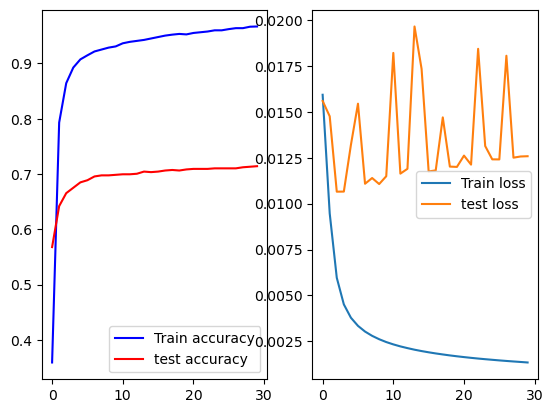

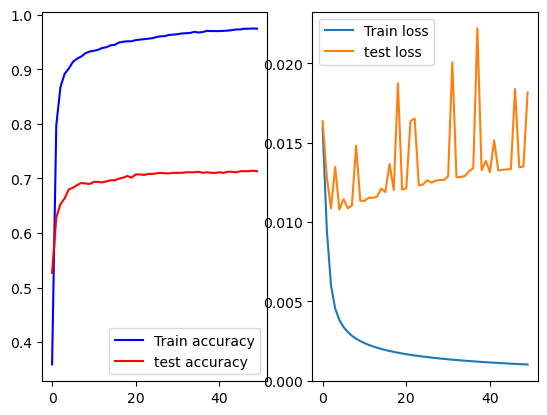

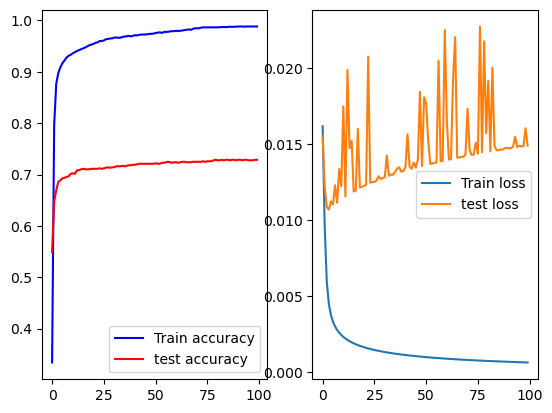

In [91]:
best_dict = {}
for i in epochs:

    best_dict[i] = big_train(epochs = i)

In [96]:
for i in best_dict.keys():
    if best_dict[i] == max(best_dict.values()):
        print(f'Лучшая точность на тесте = {max(best_dict.values())} при epochs = {i} ')

Лучшая точность на тесте = 0.728780487804878 при epochs = 100 


на эпохе 1 train_loss = 0.017531095510563192, train_accuracy = 0.16558018252933507, train_loss = 0.018315449924003788, test_accuracy = 0.2634146341463415
на эпохе 2 train_loss = 0.013220080496279481, train_accuracy = 0.549760973489787, train_loss = 0.015503585513045148, test_accuracy = 0.5170731707317073
на эпохе 3 train_loss = 0.009810072502225754, train_accuracy = 0.758800521512386, train_loss = 0.014070992004580615, test_accuracy = 0.5590243902439025
на эпохе 4 train_loss = 0.007797679529144473, train_accuracy = 0.8205128205128205, train_loss = 0.013287212557908965, test_accuracy = 0.5951219512195122
на эпохе 5 train_loss = 0.006555163798151924, train_accuracy = 0.8557149065623642, train_loss = 0.013023629072235851, test_accuracy = 0.6185365853658537
на эпохе 6 train_loss = 0.0057704802804902965, train_accuracy = 0.873967840069535, train_loss = 0.012617991377667682, test_accuracy = 0.6204878048780488
на эпохе 7 train_loss = 0.005158640466944542, train_accuracy = 0.8839634941329857, 

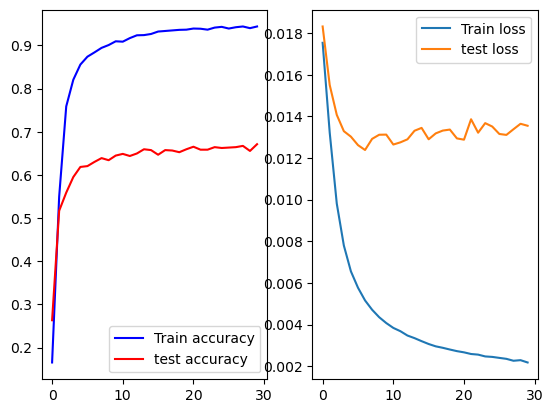

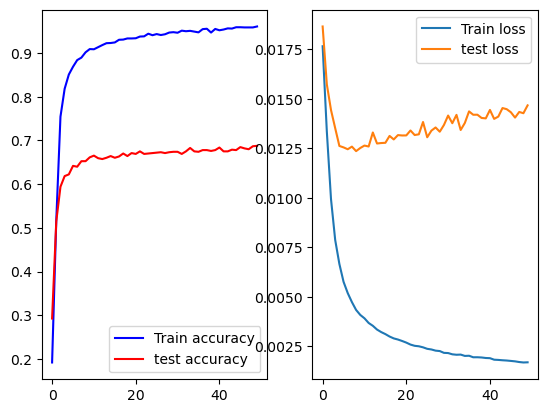

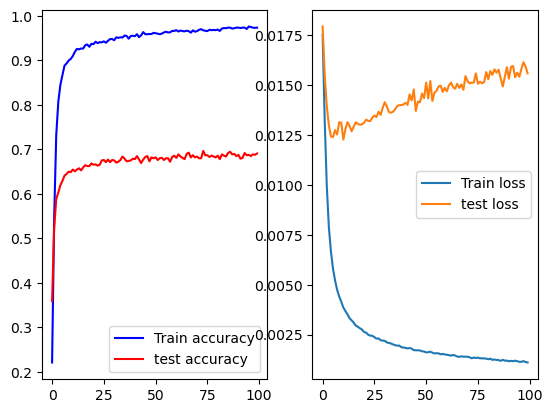

In [98]:
best_dict = {}
for i in epochs:

    best_dict[i] = big_train(model = 'cnn',epochs = i)

In [99]:
for i in best_dict.keys():
    if best_dict[i] == max(best_dict.values()):
        print(f'Лучшая точность на тесте = {max(best_dict.values())} при epochs = {i} ')

Лучшая точность на тесте = 0.6965853658536585 при epochs = 100 


#### Результаты проверки Гипотезы 
- Увеличение количества эпох приводит к росту точности на тествой выборке
- Лучшая точность достигается при epochs = 100 

### Обучение моделей с улучшенным бейзлайном
- Будем обучать модели с 100 эпохами с параметрами для трансформерной модели lr = 0.1 и momentum = 0.5 и для сверточной модели lr = 0.1 и momentum = 0.3

на эпохе 1 train_loss = 0.004573622316135007, train_accuracy = 0.8218166014776185, train_loss = 0.0213374847319068, test_accuracy = 0.6956097560975609
на эпохе 2 train_loss = 0.0014849146880672476, train_accuracy = 0.944806605823555, train_loss = 0.013917373993047854, test_accuracy = 0.7092682926829268
на эпохе 3 train_loss = 0.0010801107177056731, train_accuracy = 0.9647979139504563, train_loss = 0.014255792814783935, test_accuracy = 0.7141463414634146
на эпохе 4 train_loss = 0.0008610745925117917, train_accuracy = 0.9752281616688396, train_loss = 0.014640361526072388, test_accuracy = 0.72
на эпохе 5 train_loss = 0.0007273428634242978, train_accuracy = 0.9821816601477619, train_loss = 0.01561045963589738, test_accuracy = 0.7209756097560975
на эпохе 6 train_loss = 0.0006242165279642285, train_accuracy = 0.9860930030421556, train_loss = 0.015513264019064969, test_accuracy = 0.7248780487804878
на эпохе 7 train_loss = 0.0005519315001369818, train_accuracy = 0.9900043459365493, train_loss 

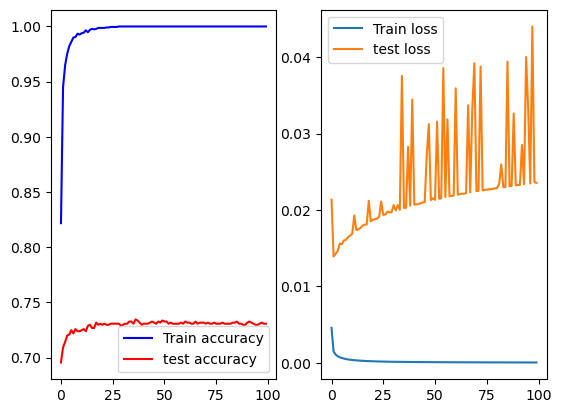

In [153]:
# Трансформерная модель
_ = big_train(model = 'vit', lr=0.1, momentum=0.5, epochs = 100)

на эпохе 1 train_loss = 0.01982799527283494, train_accuracy = 0.5136897001303781, train_loss = 0.016462765786705948, test_accuracy = 0.6439024390243903
на эпохе 2 train_loss = 0.0024091876729163643, train_accuracy = 0.9069969578444155, train_loss = 0.017781619211522545, test_accuracy = 0.6751219512195122
на эпохе 3 train_loss = 0.0018309125889647998, train_accuracy = 0.9265536723163842, train_loss = 0.018179458525122667, test_accuracy = 0.6663414634146342
на эпохе 4 train_loss = 0.00145930121096255, train_accuracy = 0.9491525423728814, train_loss = 0.016241929589248284, test_accuracy = 0.6829268292682927
на эпохе 5 train_loss = 0.001329564157127039, train_accuracy = 0.9539330725771403, train_loss = 0.01820117810877358, test_accuracy = 0.6536585365853659
на эпохе 6 train_loss = 0.0012172461333144287, train_accuracy = 0.9600173837461973, train_loss = 0.018357930532315884, test_accuracy = 0.6926829268292682
на эпохе 7 train_loss = 0.0009946696418153364, train_accuracy = 0.9661016949152542

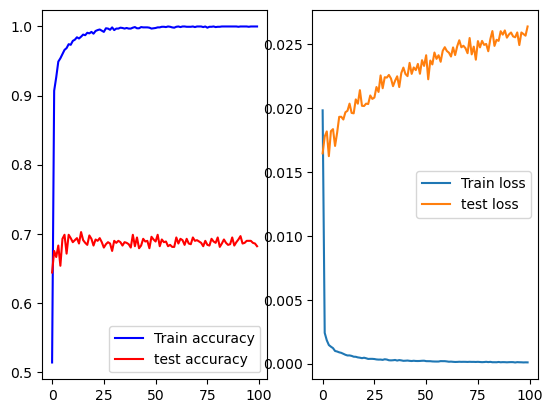

In [154]:
# Сверточная модель
_ = big_train(model = 'cnn', lr=0.1, momentum=0.5, epochs = 100)

#### Выводы 
- Улучшение бейзлайна привело к улучшению точности на тестовой выборке
- Оба типа моделей показали рост качества 

#### 4 Имплементация алгоритма машинного обучения

In [157]:
# Модель с 1 сверточным слоем
class Net_1_conv(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.fc1 = nn.Linear(290400, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = torch.flatten(x, 1) 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [158]:
model = Net_1_conv()
model = model.to(device)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)



In [159]:
all_total_loss_train, all_total_correct_train, all_total_loss_test, all_total_correct_test = [], [], [], []
for epoch in range(30):
    total_loss_train, total_correct_train, total_loss_test, total_correct_test = train(model, train_loader, test_loader, loss_fn, optimizer, device, )
    all_total_loss_train.append(total_loss_train)
    all_total_correct_train.append(total_correct_train)
    all_total_loss_test.append(total_loss_test)
    all_total_correct_test.append(total_correct_test)
    
    print(f'на эпохе {epoch+1} train_loss = {total_loss_train}, train_accuracy = {total_correct_train}, train_loss = {total_loss_test}, test_accuracy = {total_correct_test}')


на эпохе 1 train_loss = 0.01786479230861672, train_accuracy = 0.13689700130378096, train_loss = 0.019973118944865902, test_accuracy = 0.17365853658536584
на эпохе 2 train_loss = 0.01698104499060918, train_accuracy = 0.23728813559322035, train_loss = 0.019852076507196195, test_accuracy = 0.2634146341463415
на эпохе 3 train_loss = 0.015612304547412248, train_accuracy = 0.3250760538896132, train_loss = 0.01875935601025093, test_accuracy = 0.2975609756097561
на эпохе 4 train_loss = 0.01386261778984418, train_accuracy = 0.3824424163407214, train_loss = 0.017354586066269294, test_accuracy = 0.2917073170731707
на эпохе 5 train_loss = 0.01239608506024894, train_accuracy = 0.44763146458061714, train_loss = 0.016674345063000192, test_accuracy = 0.35609756097560974
на эпохе 6 train_loss = 0.011263807303798763, train_accuracy = 0.494567579313342, train_loss = 0.01631644493196069, test_accuracy = 0.37073170731707317
на эпохе 7 train_loss = 0.010505330816448798, train_accuracy = 0.5275966970882225, 

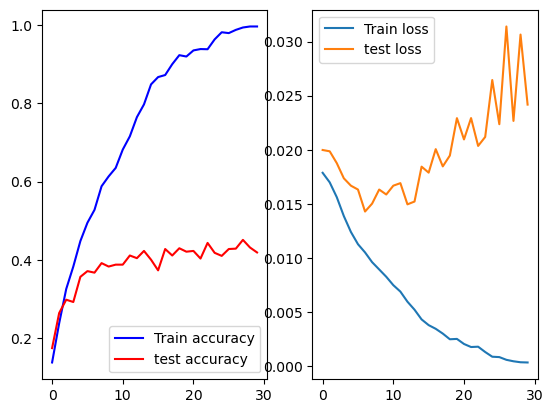

In [160]:
plot_metrics(all_total_loss_train, all_total_correct_train, all_total_loss_test, all_total_correct_test)

In [161]:
# Модель с 2 сверточными слоями
class Net_2_conv(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(44944, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [162]:
model = Net_2_conv()
model = model.to(device)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)



In [163]:
all_total_loss_train, all_total_correct_train, all_total_loss_test, all_total_correct_test = [], [], [], []
for epoch in range(30):
    total_loss_train, total_correct_train, total_loss_test, total_correct_test = train(model, train_loader, test_loader, loss_fn, optimizer, device, )
    all_total_loss_train.append(total_loss_train)
    all_total_correct_train.append(total_correct_train)
    all_total_loss_test.append(total_loss_test)
    all_total_correct_test.append(total_correct_test)
    
    print(f'на эпохе {epoch+1} train_loss = {total_loss_train}, train_accuracy = {total_correct_train}, train_loss = {total_loss_test}, test_accuracy = {total_correct_test}')


на эпохе 1 train_loss = 0.01799771165081026, train_accuracy = 0.09778357235984354, train_loss = 0.020240873243750596, test_accuracy = 0.10926829268292683
на эпохе 2 train_loss = 0.017926645299653706, train_accuracy = 0.11777488048674489, train_loss = 0.020234641796205103, test_accuracy = 0.1248780487804878
на эпохе 3 train_loss = 0.01784617493640646, train_accuracy = 0.11125597566275533, train_loss = 0.0201710091567621, test_accuracy = 0.10634146341463414
на эпохе 4 train_loss = 0.017725983374743605, train_accuracy = 0.10691003911342895, train_loss = 0.019851231691313954, test_accuracy = 0.10536585365853658
на эпохе 5 train_loss = 0.01752896217717548, train_accuracy = 0.146458061712299, train_loss = 0.020060939323611377, test_accuracy = 0.13658536585365855
на эпохе 6 train_loss = 0.017248550739976335, train_accuracy = 0.17992177314211213, train_loss = 0.019676729527915396, test_accuracy = 0.19902439024390245
на эпохе 7 train_loss = 0.016798252854229107, train_accuracy = 0.2511951325510

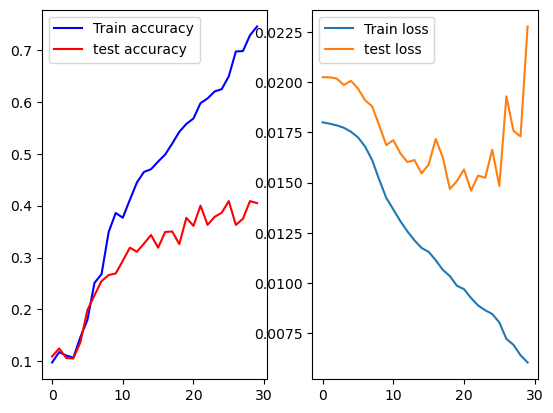

In [164]:
plot_metrics(all_total_loss_train, all_total_correct_train, all_total_loss_test, all_total_correct_test)

#### Выводы 
- Трансформерная сеть показала лучшее качество чем сверточная
- Обе сети, обученные с нуля показали более плохое качество по сравнению с предобученными сетями

#### Улучшие бейзлайна 

на эпохе 1 train_loss = 0.01795978475684241, train_accuracy = 0.11516731855714907, train_loss = 0.019812316196720775, test_accuracy = 0.12097560975609756
на эпохе 2 train_loss = 0.017578649603766185, train_accuracy = 0.18252933507170796, train_loss = 0.019390744697756885, test_accuracy = 0.16
на эпохе 3 train_loss = 0.01665474890833676, train_accuracy = 0.2598870056497175, train_loss = 0.01812358763159775, test_accuracy = 0.24585365853658536
на эпохе 4 train_loss = 0.015136555815095334, train_accuracy = 0.32811820947414166, train_loss = 0.017945856815431177, test_accuracy = 0.29560975609756096
на эпохе 5 train_loss = 0.013666384534077352, train_accuracy = 0.3754889178617992, train_loss = 0.015587135175379312, test_accuracy = 0.3278048780487805
на эпохе 6 train_loss = 0.012535745193003987, train_accuracy = 0.4280747501086484, train_loss = 0.01629158287513547, test_accuracy = 0.3297560975609756
на эпохе 7 train_loss = 0.011561962688865479, train_accuracy = 0.48457192524989134, train_loss

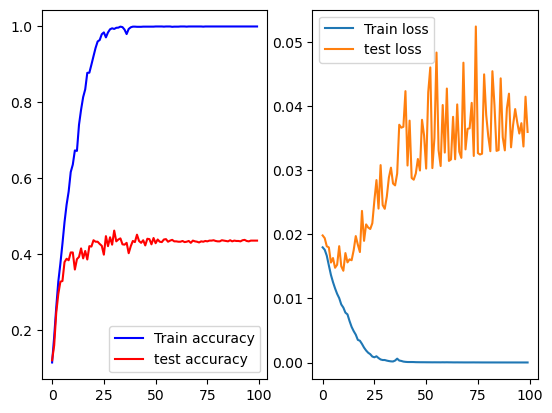

In [185]:
model = Net_1_conv()
model = model.to(device)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
num_epochs = 100
all_total_loss_train, all_total_correct_train, all_total_loss_test, all_total_correct_test = [], [], [], []
for epoch in range(num_epochs):
    total_loss_train, total_correct_train, total_loss_test, total_correct_test = train(model, train_loader, test_loader, loss_fn, optimizer, device, )
    all_total_loss_train.append(total_loss_train)
    all_total_correct_train.append(total_correct_train)
    all_total_loss_test.append(total_loss_test)
    all_total_correct_test.append(total_correct_test)
    
    print(f'на эпохе {epoch+1} train_loss = {total_loss_train}, train_accuracy = {total_correct_train}, train_loss = {total_loss_test}, test_accuracy = {total_correct_test}')
plot_metrics(all_total_loss_train, all_total_correct_train, all_total_loss_test, all_total_correct_test)

на эпохе 1 train_loss = 0.01781435584773296, train_accuracy = 0.1316818774445893, train_loss = 0.020223608249571264, test_accuracy = 0.10536585365853658
на эпохе 2 train_loss = 0.016436068403466998, train_accuracy = 0.18383311603650587, train_loss = 0.01790891565927645, test_accuracy = 0.18439024390243902
на эпохе 3 train_loss = 0.016980201873712984, train_accuracy = 0.16166883963494133, train_loss = 0.016756154967517388, test_accuracy = 0.19609756097560976
на эпохе 4 train_loss = 0.015182699135519638, train_accuracy = 0.2333767926988266, train_loss = 0.016792830955691455, test_accuracy = 0.19707317073170733
на эпохе 5 train_loss = 0.015540768197700802, train_accuracy = 0.21164710995219468, train_loss = 0.016208124393370094, test_accuracy = 0.26439024390243904
на эпохе 6 train_loss = 0.014670708810490455, train_accuracy = 0.2494567579313342, train_loss = 0.017078913130411287, test_accuracy = 0.21073170731707316
на эпохе 7 train_loss = 0.014139594901183127, train_accuracy = 0.2750977835

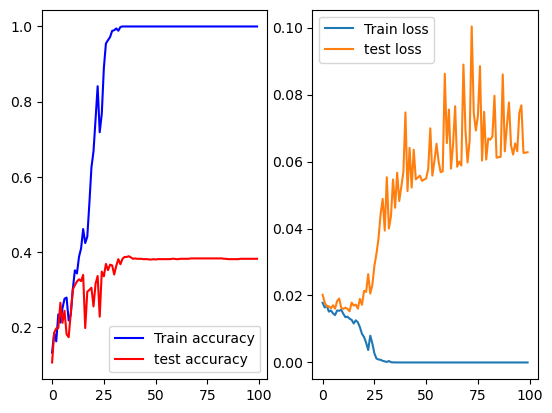

In [186]:
model = Net_2_conv()
model = model.to(device)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.5)
num_epochs = 100
all_total_loss_train, all_total_correct_train, all_total_loss_test, all_total_correct_test = [], [], [], []
for epoch in range(num_epochs):
    total_loss_train, total_correct_train, total_loss_test, total_correct_test = train(model, train_loader, test_loader, loss_fn, optimizer, device, )
    all_total_loss_train.append(total_loss_train)
    all_total_correct_train.append(total_correct_train)
    all_total_loss_test.append(total_loss_test)
    all_total_correct_test.append(total_correct_test)
    
    print(f'на эпохе {epoch+1} train_loss = {total_loss_train}, train_accuracy = {total_correct_train}, train_loss = {total_loss_test}, test_accuracy = {total_correct_test}')
plot_metrics(all_total_loss_train, all_total_correct_train, all_total_loss_test, all_total_correct_test)

#### Выводы 
- Улучшение бейзлайна улучшило качество моделей на тесте
- Несмотря на улучшение бейзлайна модели не смогли показать лучшее качество чем предобученные модели 